In [1]:
"""
The following is an import of PyTorch libraries.
"""
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
from data_loader import NEFG3x3Set

# print(f"default data type: {torch.get_default_dtype()}")
# print(f"new data type: {torch.set_default_dtype(torch.float32)}")

"""
Determine if any GPUs are available
"""
if torch.cuda.is_available():
    device = "cuda" # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "mps" # Apple GPU
else:
    device = "cpu" # Defaults to CPU if NVIDIA GPU/Apple GPU aren't available

print(f"Using device: {device}")


"""
A Convolutional Variational Autoencoder
"""
class VAE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=32*63*18, zDim=256):
        super(VAE, self).__init__()

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 16, 5)
        self.encConv2 = nn.Conv2d(16, 32, 5)
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 5)
        
        self.feature_dim = featureDim

    def encoder(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, self.feature_dim)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 32,63,18)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar
    



    """
Initialize Hyperparameters
"""
batch_size = 128
learning_rate = 1e-2
num_epochs = 20


"""
Create dataloaders to feed data into the neural network
Default MNIST dataset is used and standard train/test split is performed
"""
dataset = NEFG3x3Set("info_dat_charge.csv",
                     "data/3x12_16_damp00", "dat_charge", transform=True, device=device)
length = len(dataset)
train_split = math.floor(length*.7)
test_split = length - train_split

train_inds, test_inds = torch.utils.data.random_split(
    dataset, [train_split, test_split], generator=torch.Generator().manual_seed(42))
train_data = torch.utils.data.DataLoader(dataset=train_inds, batch_size=5,
                                         shuffle=True)
test_data = torch.utils.data.DataLoader(dataset=test_inds, batch_size=5,
                                        shuffle=True)

"""
Initialize the network and the Adam optimizer
"""
net = VAE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
minLoss =  100000000000
loss = 0
params = net.state_dict()
for epoch in range(num_epochs):
    loss = 0
    for idx, data in enumerate(train_data, 0):
        (inp,_ , imgs, _,_,_) = data
        imgs = imgs.float().to(device)

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = net(imgs)
        
        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.mse_loss(out, imgs, reduction='sum') + kl_divergence
        
        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss = 0
    
    net.eval()
    with torch.no_grad():
        for data in test_data:
            (inp,cmp , imgs, _,_,_) = data
            imgs = imgs.float().to(device)
            img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
            
            # cmp = cmp.float().to(device)
            
            out, mu, logVAR = net(imgs)
            kl_divergence = 0.5 * torch.sum(-1 - logVAR + mu.pow(2) + logVAR.exp())
            loss += F.mse_loss(out, imgs, reduction='sum') + kl_divergence
        
        loss =loss/len(test_data)
        print('Epoch {}: Loss {}'.format(epoch,loss))
        
        if loss<minLoss:
            minLoss=loss
            params=net.state_dict()
            # for g in optimizer.param_groups:
            #     print("double rate")
            #     g['lr'] = g['lr']*2
        else:
            net.load_state_dict(params)
            print("Loaded params")
            for g in optimizer.param_groups:
                print("split rate")
                g['lr'] = g['lr']/2

            

default data type: torch.float32
new data type: torch.float32
tensor type: torch.float32
Using device: mps
Epoch 0: Loss 227.05934143066406
Epoch 1: Loss 128.07949829101562
Epoch 2: Loss 126.49866485595703
Epoch 3: Loss 204.45980834960938
Loaded params
split rate
Epoch 4: Loss 96.24490356445312
Epoch 5: Loss 94.71830749511719
Epoch 6: Loss 99.86216735839844
Loaded params
split rate
Epoch 7: Loss 86.15086364746094
Epoch 8: Loss 85.70953369140625
Epoch 9: Loss 83.90100860595703
Epoch 10: Loss 81.21861267089844
Epoch 11: Loss 80.41902923583984
Epoch 12: Loss 80.36553192138672
Epoch 13: Loss 80.2384262084961
Epoch 14: Loss 79.3012466430664
Epoch 15: Loss 81.42992401123047
Loaded params
split rate
Epoch 16: Loss 90.70861053466797
Loaded params
split rate
Epoch 17: Loss 77.94110870361328
Epoch 18: Loss 77.255126953125
Epoch 19: Loss 76.94143676757812


tensor(34.2528, device='mps:0')
tensor(33.9705, device='mps:0')


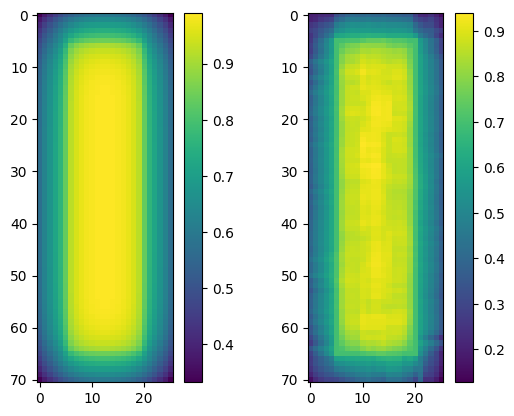

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random

net.eval()
with torch.no_grad():
    for data in test_data:
        (inp,cmp , imgs, _,_,_) = data
        imgs = imgs.float().to(device)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        
        cmp = cmp.float().to(device)
        
        plt.subplot(121)
        a = plt.imshow(np.squeeze(img))
        c_bar = plt.colorbar(a)
        out, mu, logVAR = net(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        a = plt.imshow(np.squeeze(outimg))
        c_bar = plt.colorbar(a)
        print(F.mse_loss(imgs[0], out[0], reduction='sum'))
        print(F.mse_loss(cmp[0], out[0], reduction='sum'))
        
        break